In [13]:
import pandas as pd
import numpy as np
import datetime
import tqdm

import matplotlib.pyplot as plt

## Data Preprocessing

In [8]:
stocks = pd.read_json(r"data.json")

In [9]:
def preprocess_dataset (stocks):
    stocks.rename({"priceCurrencyOne":"priceUSD"}, axis = 1, inplace = True)
    stocks.rename({"priceCurrencyTwo":"priceEUR"}, axis = 1, inplace = True)

    stocks.drop(["currencyOne", "currencyTwo"], axis = 1, inplace = True)
    return stocks

def extract_currency (stocks, currency):
    return stocks[(stocks['tmsp']!='null')
                &(stocks['priceUSD']!='null')
                &(stocks['priceEUR']!='null')
               &(stocks['cryptoCurrency']==currency)]

def preprocess_currency (sample):
    sample.tmsp = [datetime.datetime.fromtimestamp(x) for x in sample.tmsp.astype(int)]
    sample.priceUSD = sample.priceUSD.astype(float)
    sample.priceEUR = sample.priceEUR.astype(float)
    return sample

In [10]:
stocks = preprocess_dataset(stocks)
sample_BTC = extract_currency(stocks, "BTC")
sample_BTC = preprocess_currency(sample_BTC)

## Features

In [11]:
sample_BTC["diff_eur"] = (sample_BTC.priceEUR/sample_BTC.priceEUR.shift(1))-1
sample_BTC["diff_usd"] = (sample_BTC.priceUSD/sample_BTC.priceUSD.shift(1))-1

## Parameter tuning

In [18]:
def list_pop (my_list):
    my_list_new = my_list.copy()
    return list(filter(lambda a: a != "wait", my_list_new))[-1]

def trading_func (timespan, sensitivity, elements_to_process, data):
    final_list = []
    
    for i in tqdm.tqdm(list(range(elements_to_process))): #53549
        sample_BTC_new = data[(data.tmsp>=(data.tmsp[i]- pd.to_timedelta(f"00:00:{timespan}"))) 
                              & (data.tmsp<=data.tmsp[i])].copy()
        value = ((sample_BTC_new[sample_BTC_new.tmsp == sample_BTC_new.tmsp.max()].priceUSD.values[0])/sample_BTC_new[sample_BTC_new.tmsp== sample_BTC_new.tmsp.min()].priceUSD.values[0])-1 

        if ((abs(value) > sensitivity)) and value>0:
            try:
                if (list_pop(final_list) != 'buy') == True:
                    final_list.append("buy") 
                else:
                    final_list.append("wait") 
            except:
                final_list.append("buy")

        elif ((abs(value) > sensitivity)) and value<0: 
            try:
                if (list_pop(final_list) != 'sell') == True:
                    final_list.append("sell") 
                else:
                    final_list.append("wait") 
            except:
                final_list.append("sell")

        else: 
            final_list.append("wait")
    
    return final_list

In [66]:
def list_pop (my_list):
    my_list_new = my_list.copy()
    return list(filter(lambda a: a != "wait", my_list_new))[-1]

def trading_func (timespan, sensitivity, elements_to_process, data):
    final_list = [[-1, 'placeholder']]
    
    for i in tqdm.tqdm(list(range(elements_to_process))): #53549
        sample_BTC_new = data[(data.tmsp>=(data.tmsp[i]- pd.to_timedelta(f"00:00:{timespan}"))) 
                              & (data.tmsp<=data.tmsp[i])].copy()
        value = ((sample_BTC_new[sample_BTC_new.tmsp == sample_BTC_new.tmsp.max()].priceUSD.values[0])/sample_BTC_new[sample_BTC_new.tmsp== sample_BTC_new.tmsp.min()].priceUSD.values[0])-1 

        if ((abs(value) > sensitivity)) and value>0:
            if final_list[-1][1] != 'buy':
                final_list.append([i,"buy"]) 

        elif ((abs(value) > sensitivity)) and value<0: 
            if final_list[-1][1] != 'sell':
                final_list.append([i, "sell"]) 
    final_list.remove([-1, 'placeholder'])
    return final_list

In [67]:
timespan = 16
sensitivity = 0

result = trading_func(timespan=16, sensitivity=0, elements_to_process=1000, data=sample_BTC)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.53it/s]


In [75]:
sample_BTC = sample_BTC.join(pd.DataFrame(result, columns = ["index", "decision_"]).set_index("index")).fillna('wait')

,id,tmsp,priceUSD,priceEUR,cryptoCurrency,diff_eur,diff_usd,decision,profit,decision_
0,1,2021-04-19 23:14:24,56314.7,46807.7,BTC,wait,wait,buy,0.000000,wait
1,2,2021-04-19 23:14:26,56314.7,46807.7,BTC,0,0,wait,0.000000,wait
2,3,2021-04-19 23:14:27,56314.7,46807.7,BTC,0,0,wait,0.000000,wait
3,4,2021-04-19 23:14:29,56314.7,46807.7,BTC,0,0,wait,0.000000,wait
4,5,2021-04-19 23:14:31,56314.7,46807.7,BTC,0,0,wait,0.000000,wait
...,...,...,...,...,...,...,...,...,...,...
53544,53545,2021-04-21 16:01:56,55731.7,46404.3,BTC,0,-5.74147e-05,sell,-0.008618,wait
53545,53546,2021-04-21 16:01:57,55731.7,46404.3,BTC,0,0,wait,0.000000,wait
53546,53547,2021-04-21 16:01:59,55731.7,46404.3,BTC,0,0,wait,0.000000,wait
53547,53548,2021-04-21 16:02:01,55731.7,46404.3,BTC,0,0,wait,0.000000,wait


In [39]:
def calc_profit (sample_BTC):
    basic_value = sample_BTC.priceEUR[0]
    sample_BTC["profit"] = 0
    sample_BTC["profit"] = np.where(sample_BTC.decision.isin(["buy", "sell"]), (sample_BTC.priceEUR/basic_value)-1, sample_BTC.profit)
    return sample_BTC

In [40]:
sample_BTC = calc_profit(sample_BTC)

<ipython-input-39-9a56397beb84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_BTC.decision[0] = 'buy'


<AxesSubplot:xlabel='tmsp', ylabel='profit'>

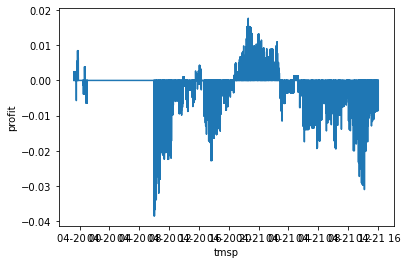

In [47]:
import seaborn as sns
sns.lineplot(data = sample_BTC, x = 'tmsp', y = "profit")

In [48]:
sample_BTC.profit.describe()

count    53549.000000
mean        -0.000177
std          0.002080
min         -0.038615
25%          0.000000
50%          0.000000
75%          0.000000
max          0.017717
Name: profit, dtype: float64